This notebook is used to analyse the growth curve experiments and produce the visualizations for that portion of figure 5. it accompanies the inhibition curve analysis notebook also used for figure 5.

In [ ]:
#setup
import os
import pandas as pd
import string
import numpy as np

#for growth curves
from croissance import process_curve

import matplotlib.pyplot as plt
import seaborn as sns

#get data dir
pwd = os.getcwd()
data_dir = os.path.join(pwd, "biobloomrxiv_source_data", "salt_kinetic_growth_data") #suggested data directory, data available at figshare 10.6084/m9.figshare.31053121
data_filename = "20250726_kinetic_MS_scrubbed.txt"
metadata_filename = "strains_kinetic.txt"

#output dir
fig_out = os.path.join(pwd, "figures", 'fig5')



Growth curve analysis

In [2]:
#load kinetic growth curve data
# File path
filepath = os.path.join(data_dir, data_filename)

# Read raw lines
with open(filepath, 'r') as f:
    lines = f.readlines()

# Prepare to collect tidy dataframes
tidy_plates = []

# Group lines into 9-line blocks
for i in range(0, len(lines), 9):
    block = lines[i:i+9]
    if len(block) < 9:
        continue  # Skip incomplete blocks

    data_lines = block[1:]  # skip the header line
    data_lines = [line.strip().split('\t') for line in data_lines]
    
    # Convert to DataFrame
    df = pd.DataFrame(data_lines)
    df.index = list(string.ascii_uppercase[:8])  # rows A–H
    df.columns = range(1, 13)                    # columns 1–12

    # Tidy the DataFrame
    tidy_df = df.stack().reset_index()
    tidy_df.columns = ['row', 'column', 'OD']
    tidy_df['well'] = tidy_df['row'] + tidy_df['column'].astype(str)
    tidy_df.drop(columns=['row', 'column'], inplace=True)
    tidy_df['timepoint'] = i // 9 + 1  # plate number (1-based)

    tidy_plates.append(tidy_df)

# Combine all timepoints
kinetic_data = pd.concat(tidy_plates, ignore_index=True)
kinetic_data['time_minutes'] = kinetic_data['timepoint']*15 - 15
kinetic_data

,OD,well,timepoint,time_minutes
0,0.0948,A1,1,0
1,0.0976,A2,1,0
2,0.0979,A3,1,0
3,0.098,A4,1,0
4,0.0972,A5,1,0
...,...,...,...,...
8059,0.3018,H8,84,1245
8060,0.7075,H9,84,1245
8061,0.362,H10,84,1245
8062,0.3645,H11,84,1245


In [7]:
#import kinetic metadata (strains)
# Prepare list to collect each tidy dataframe
tidy_plates = []

# single file
filepath = os.path.join(data_dir, metadata_filename)

df = pd.read_csv(filepath, sep='\t', header=None)

# Assign row and column labels
df.index = list(string.ascii_uppercase[:8])  # A to H
df.columns = range(1, 13)                    # 1 to 12

# Tidy it up
tidy_df = df.stack().reset_index()
tidy_df.columns = ['row', 'column', 'strain']
tidy_df['well'] = tidy_df['row'] + tidy_df['column'].astype(str)
tidy_df.drop(columns = ['row', 'column'],inplace=True)

# specify salt concentration, which is always 4%
tidy_df['added_salt_pct'] = "4"


# set strain data
kinetic_strain_data = tidy_df
#correct strain that didn't pass sequencing == WT
kinetic_strain_data_updated = kinetic_strain_data.copy()
kinetic_strain_data_updated.loc[
    kinetic_strain_data_updated['strain'] == "s.Ek.E.01389", 'strain'
] = "s.Ek.E.01344"

kinetic_strain_data_updated

,strain,well,added_salt_pct
0,s.Ek.E.01387,A1,4
1,s.Ek.E.01344,A2,4
2,s.Ek.E.01393,A3,4
3,s.Ek.E.01387,A4,4
4,s.Ek.E.01344,A5,4
...,...,...,...
91,s.Ek.E.00157,H8,4
92,s.Ek.E.01396,H9,4
93,s.Ek.E.00157,H10,4
94,s.Ek.E.00157,H11,4


In [18]:
#add strain labels to data
labeled_kinetic = pd.merge(kinetic_data, kinetic_strain_data_updated, on = ['well'])
#!pip install pygro
labeled_kinetic['OD'] = pd.to_numeric(labeled_kinetic['OD'], errors='coerce') #force OD to be int64

#fetch strain labels
strainlabels = pd.read_csv(os.path.join(data_dir, "strainlabels.csv"))
labeled_kinetic2 = pd.merge(labeled_kinetic, strainlabels, on = ['strain'])

#remove internal controls
labeled_kinetic2 = labeled_kinetic2[~labeled_kinetic2['label'].isin(['K-12 parent', 'K-12 + 6.2kb HGT hit plasmid'])]

labeled_kinetic2

,OD,well,timepoint,time_minutes,strain,added_salt_pct,label
0,0.0948,A1,1,0,s.Ek.E.01387,4,hflK*
1,0.0976,A2,1,0,s.Ek.E.01344,4,K-12 BioBloom parent
2,0.0979,A3,1,0,s.Ek.E.01393,4,yidk*
3,0.0980,A4,1,0,s.Ek.E.01387,4,hflK*
4,0.0972,A5,1,0,s.Ek.E.01344,4,K-12 BioBloom parent
...,...,...,...,...,...,...,...
8051,0.6507,G12,84,1245,s.Ek.E.01395,4,hflC*
8054,0.6901,H3,84,1245,s.Ek.E.01396,4,mepM*2
8057,0.5741,H6,84,1245,s.Ek.E.01396,4,mepM*2
8060,0.7075,H9,84,1245,s.Ek.E.01396,4,mepM*2


In [19]:
###growth curve analysis using croissance
# 
# # Convert minutes to hours to match croissance expectations
labeled_kinetic2['time_hours'] = labeled_kinetic2['time_minutes'] / 60.0

results = []

for well, grp in labeled_kinetic2.groupby('well'):
    # Sort by time
    grp = grp.sort_values('time_hours')

    # Create the series
    curve = pd.Series(data=grp['OD'].values, index=grp['time_hours'].values, name=well)

    # Ensure time is float and slightly shift if 0.0
    curve.index = pd.to_numeric(curve.index, errors='coerce')
    curve = curve.dropna()
    if curve.index.min() == 0.0:
        curve.index += 1e-4 ### this avoids division by zero errors
    curve = curve.astype(float)
    
    # Process and extract growth phases
    res = process_curve(curve)

    for phase in res.growth_phases:
        results.append({
            'well': well,
            'strain': grp['strain'].iloc[0],
            'phase': phase.rank,
            'start_time_h': phase.start,
            'end_time_h': phase.end,
            'growth_rate_mu': phase.slope,
            'lag_intercept': phase.intercept,
            'initial_density_n0': phase.n0
        })

# Compile results into a tidy DataFrame
growth_metrics = pd.DataFrame(results)
print(growth_metrics)


/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/croissance/estimation/smoothing/segments.py:20: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  window = series[i : i + size * increment]
/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/croissance/estimation/smoothing/segments.py:61: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  window = series[start:end]
/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/croissance/estimation/smoothing/segments.py:20: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing

   well        strain  phase  start_time_h  end_time_h  growth_rate_mu  \
0    A1  s.Ek.E.01387  100.0        0.2501      6.7501        0.454011   
1   A10  s.Ek.E.01387  100.0        0.7501      6.7501        0.427885   
2   A11  s.Ek.E.01344  100.0        0.0001      5.5001        0.571751   
3   A12  s.Ek.E.01393  100.0        0.7501      6.0001        0.536406   
4    A2  s.Ek.E.01344  100.0        0.5001      5.5001        0.599353   
..  ...           ...    ...           ...         ...             ...   
67   G9  s.Ek.E.01395  100.0        0.7501      6.0001        0.431062   
68  H12  s.Ek.E.01396  100.0        0.0001      6.2501        0.481221   
69   H3  s.Ek.E.01396  100.0        0.7501      6.5001        0.433141   
70   H6  s.Ek.E.01396  100.0        0.5001      6.5001        0.429766   
71   H9  s.Ek.E.01396  100.0        0.2501      6.0001        0.488475   

    lag_intercept  initial_density_n0  
0        9.341702            0.076516  
1        9.256048            0.

/Users/Max_Schubert/miniconda3/lib/python3.12/site-packages/croissance/estimation/smoothing/segments.py:61: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  window = series[start:end]


In [ ]:
#label strains
growth_metrics_labeled = pd.merge(growth_metrics, strainlabels, on= "strain")

#also annotate with ic50 for plotting order
#these ic50 values are output from the inhibition curve analysis notebook
ic50_df = pd.read_csv(os.path.join(data_dir, 'figure5_biobloom_ic50_values.csv'))
growth_metrics_labeled = pd.merge(growth_metrics_labeled, ic50_df, on= "label")
growth_metrics_labeled

,well,strain,phase,start_time_h,end_time_h,growth_rate_mu,lag_intercept,initial_density_n0,label,IC50
0,A1,s.Ek.E.01387,100.0,0.2501,6.7501,0.454011,9.341702,0.076516,hflK*,6.379802
1,A10,s.Ek.E.01387,100.0,0.7501,6.7501,0.427885,9.256048,0.068566,hflK*,6.379802
2,A11,s.Ek.E.01344,100.0,0.0001,5.5001,0.571751,8.580975,0.091599,K-12 BioBloom parent,3.454277
3,A12,s.Ek.E.01393,100.0,0.7501,6.0001,0.536406,9.016315,0.094073,yidk*,3.611514
4,A2,s.Ek.E.01344,100.0,0.5001,5.5001,0.599353,8.424907,0.092146,K-12 BioBloom parent,3.454277
...,...,...,...,...,...,...,...,...,...,...
67,G9,s.Ek.E.01395,100.0,0.7501,6.0001,0.431062,8.479066,0.062864,hflC*,6.529158
68,H12,s.Ek.E.01396,100.0,0.0001,6.2501,0.481221,8.588714,0.081169,mepM*2,6.311473
69,H3,s.Ek.E.01396,100.0,0.7501,6.5001,0.433141,8.650217,0.065555,mepM*2,6.311473
70,H6,s.Ek.E.01396,100.0,0.5001,6.5001,0.429766,9.204981,0.076948,mepM*2,6.311473


In [113]:
#set color map for raw data figure


#fix labels for plotting
labeled_kinetic2["label_fixed"] = (
    labeled_kinetic2["label"].str.replace("_", " ", regex=False)
)

labels = labeled_kinetic2["label_fixed"].unique()
base_colors = sns.color_palette("Set2", len(labels))
color_map = dict(zip(labels, base_colors))

# override WT
color_map["K-12 BioBloom parent"] = "red"

labeled_kinetic2

,OD,well,timepoint,time_minutes,strain,added_salt_pct,label,time_hours,label_fixed
0,0.0948,A1,1,0,s.Ek.E.01387,4,hflK*,0.00,hflK*
1,0.0976,A2,1,0,s.Ek.E.01344,4,K-12 BioBloom parent,0.00,K-12 BioBloom parent
2,0.0979,A3,1,0,s.Ek.E.01393,4,yidk*,0.00,yidk*
3,0.0980,A4,1,0,s.Ek.E.01387,4,hflK*,0.00,hflK*
4,0.0972,A5,1,0,s.Ek.E.01344,4,K-12 BioBloom parent,0.00,K-12 BioBloom parent
...,...,...,...,...,...,...,...,...,...
8051,0.6507,G12,84,1245,s.Ek.E.01395,4,hflC*,20.75,hflC*
8054,0.6901,H3,84,1245,s.Ek.E.01396,4,mepM*2,20.75,mepM*2
8057,0.5741,H6,84,1245,s.Ek.E.01396,4,mepM*2,20.75,mepM*2
8060,0.7075,H9,84,1245,s.Ek.E.01396,4,mepM*2,20.75,mepM*2


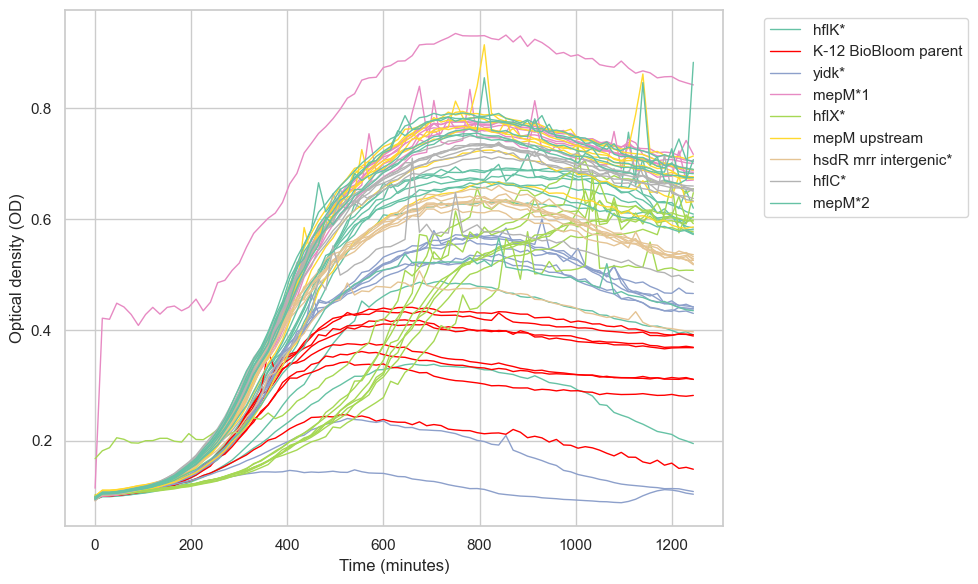

In [114]:
##plot raw data for supplement, context

# Set seaborn style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=labeled_kinetic2, 
    x='time_minutes', 
    y='OD', 
    hue='label_fixed',       # color by strain
    units='well',       # individual lines per well
    estimator=None,     # ensures no summary/mean, plots raw lines
    linewidth=1,
    palette=color_map   # refers to label colormap
)

# Customize plot
#plt.title("Growth Curves in 5% salt, raw data")
plt.xlabel("Time (minutes)")
plt.ylabel("Optical density (OD)")
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

#save for supplement
plt.savefig(os.path.join(fig_out, "fig5_growthcurves_raw.pdf"), dpi=600)

plt.show()


In [116]:
#prepare for plotting growth metrics
growth_metrics_labeled["label_fixed"] = (
    growth_metrics_labeled["label"].str.replace("_", " ", regex=False)
)

growth_metrics_labeled["label_wrapped"] = (
    growth_metrics_labeled["label_fixed"].str.replace(" ", "\n", regex=False)
)
#growth_metrics_labeled['label_wrapped'] = growth_metrics_labeled['label_fixed'].str.wrap(20)


#colormap matching hypotheses from full genome

biobloom_palette = {
    "K-12 BioBloom parent": "blue",
    "hflC*": "orange",
    "hflK*": "orange",
    "hflX*": "orange",
    "hsdR mrr intergenic*": "red",
    "mepM*1": "green",
    "mepM*2": "green",
    "mepM upstream": "green",
    "yidk*": "red",
}


##these functions enable the second axis
def mu_to_dt_min(mu):
    return (np.log(2) / mu) * 60.0
def dt_min_to_mu(dt):
    return np.log(2) / (dt / 60.0)

#prepare order of x-axis
label_order = (
    growth_metrics_labeled
    .sort_values("IC50")
    ["label_wrapped"]
    .unique()
)


In [117]:
growth_metrics_labeled

,well,strain,phase,start_time_h,end_time_h,growth_rate_mu,lag_intercept,initial_density_n0,label,IC50,label_fixed,label_wrapped
0,A1,s.Ek.E.01387,100.0,0.2501,6.7501,0.454011,9.341702,0.076516,hflK*,6.379802,hflK*,hflK*
1,A10,s.Ek.E.01387,100.0,0.7501,6.7501,0.427885,9.256048,0.068566,hflK*,6.379802,hflK*,hflK*
2,A11,s.Ek.E.01344,100.0,0.0001,5.5001,0.571751,8.580975,0.091599,K-12 BioBloom parent,3.454277,K-12 BioBloom parent,K-12\nBioBloom\nparent
3,A12,s.Ek.E.01393,100.0,0.7501,6.0001,0.536406,9.016315,0.094073,yidk*,3.611514,yidk*,yidk*
4,A2,s.Ek.E.01344,100.0,0.5001,5.5001,0.599353,8.424907,0.092146,K-12 BioBloom parent,3.454277,K-12 BioBloom parent,K-12\nBioBloom\nparent
...,...,...,...,...,...,...,...,...,...,...,...,...
67,G9,s.Ek.E.01395,100.0,0.7501,6.0001,0.431062,8.479066,0.062864,hflC*,6.529158,hflC*,hflC*
68,H12,s.Ek.E.01396,100.0,0.0001,6.2501,0.481221,8.588714,0.081169,mepM*2,6.311473,mepM*2,mepM*2
69,H3,s.Ek.E.01396,100.0,0.7501,6.5001,0.433141,8.650217,0.065555,mepM*2,6.311473,mepM*2,mepM*2
70,H6,s.Ek.E.01396,100.0,0.5001,6.5001,0.429766,9.204981,0.076948,mepM*2,6.311473,mepM*2,mepM*2


In [145]:
#need to add a column for the confluent OD at 20 hours
twenty_hour_OD = labeled_kinetic2[labeled_kinetic2['time_minutes'] == 1200]
#labeled_kinetic2['OD_20h'] = labeled_kinetic2['time_minutes'].apply(lambda x: labeled_kinetic2.loc[labeled_kinetic2['time_minutes'] == 1200, 'OD'].values[0] if x == 1200 else np.nan)

#plotting confluent OD
twenty_hour_OD['OD_20h'] = twenty_hour_OD['OD']
twenty_hour_OD.drop(columns = ['OD','timepoint','time_minutes','added_salt_pct','label','time_hours','label_fixed'], inplace = True)
twenty_hour_OD

#merge to growth metrics
growth_metrics_labeled2 = pd.merge(growth_metrics_labeled, twenty_hour_OD, on = ['well','strain'])


#plotting order, by IC50 (have to use same variable for x-axis and sorting)
label_order = (
    growth_metrics_labeled2
    .groupby("label_fixed", as_index=False)["IC50"]
    .mean()
    .sort_values("IC50")["label_fixed"]
)

growth_metrics_labeled2


/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_8790/774139774.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_hour_OD['OD_20h'] = twenty_hour_OD['OD']
/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_8790/774139774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twenty_hour_OD.drop(columns = ['OD','timepoint','time_minutes','added_salt_pct','label','time_hours','label_fixed'], inplace = True)


,well,strain,phase,start_time_h,end_time_h,growth_rate_mu,lag_intercept,initial_density_n0,label,IC50,label_fixed,label_wrapped,OD_20h
0,A1,s.Ek.E.01387,100.0,0.2501,6.7501,0.454011,9.341702,0.076516,hflK*,6.379802,hflK*,hflK*,0.6077
1,A10,s.Ek.E.01387,100.0,0.7501,6.7501,0.427885,9.256048,0.068566,hflK*,6.379802,hflK*,hflK*,0.6300
2,A11,s.Ek.E.01344,100.0,0.0001,5.5001,0.571751,8.580975,0.091599,K-12 BioBloom parent,3.454277,K-12 BioBloom parent,K-12\nBioBloom\nparent,0.3677
3,A12,s.Ek.E.01393,100.0,0.7501,6.0001,0.536406,9.016315,0.094073,yidk*,3.611514,yidk*,yidk*,0.4337
4,A2,s.Ek.E.01344,100.0,0.5001,5.5001,0.599353,8.424907,0.092146,K-12 BioBloom parent,3.454277,K-12 BioBloom parent,K-12\nBioBloom\nparent,0.3694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,G9,s.Ek.E.01395,100.0,0.7501,6.0001,0.431062,8.479066,0.062864,hflC*,6.529158,hflC*,hflC*,0.6612
68,H12,s.Ek.E.01396,100.0,0.0001,6.2501,0.481221,8.588714,0.081169,mepM*2,6.311473,mepM*2,mepM*2,0.6792
69,H3,s.Ek.E.01396,100.0,0.7501,6.5001,0.433141,8.650217,0.065555,mepM*2,6.311473,mepM*2,mepM*2,0.6990
70,H6,s.Ek.E.01396,100.0,0.5001,6.5001,0.429766,9.204981,0.076948,mepM*2,6.311473,mepM*2,mepM*2,0.5820


/var/folders/th/8qkg74gx5p18qtdnw7csq9d00000gq/T/ipykernel_8790/3442420281.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1].set_xticklabels(


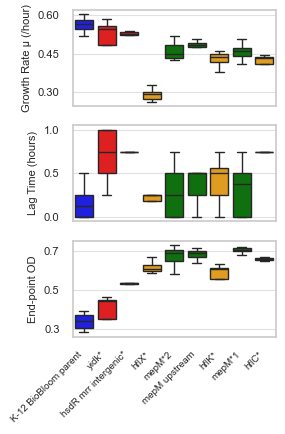

In [149]:
###build stacked subplots for growth rates, lag time, and confluent OD
from matplotlib.ticker import FixedLocator

fig, axs = plt.subplots(3, 1, figsize=(3, 4.5), sharex=True)
fontsize = 8

into_plot = growth_metrics_labeled2

# Plot growth rates
sns.boxplot(
    data=into_plot,
    x='label_fixed',
    y='growth_rate_mu',
    hue='label_fixed',
    palette=biobloom_palette,
    showfliers=False,
    order=label_order,
    ax=axs[0],
    legend = False
)

# Plot lag time
sns.boxplot(
    data=into_plot,
    x='label_fixed',
    y='start_time_h',
    hue='label_fixed',
    palette=biobloom_palette,
    showfliers=False,
    order=label_order,
    ax=axs[1],
    legend = False
)

# Plot confluent OD
sns.boxplot(
    data=into_plot,
    x='label_fixed',
    y='OD_20h',
    hue='label_fixed',
    palette=biobloom_palette,
    showfliers=False,
    order=label_order,
    ax=axs[2],
    legend = False
)




# Customize plot
axs[0].set_ylabel("Growth Rate μ (/hour)", fontsize = fontsize)
axs[1].set_ylabel("Lag Time (hours)", fontsize = fontsize)
axs[2].set_ylabel("End-point OD", fontsize = fontsize)

#format y-axis, ticks
y_ticks = {
    0: [0.3, 0.45, 0.6],   # growth_rate_mu
    1: [0, 0.5,1],        # start_time_h
    2: [0.3, 0.5, 0.7],     # OD_20h
}
for i, ax in enumerate(axs):
    ticks = y_ticks[i]
    #ax.set_ylim(min(ticks), max(ticks))
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.grid(axis="y", which="major", linewidth=0.8, alpha=0.6)
    ax.tick_params(axis="y", labelsize=fontsize)


# Set x-axis labels
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[2].set_xlabel("")

#format labels
axs[-1].set_xticklabels(
    axs[-1].get_xticklabels(),
    rotation=45,
    ha="right",
    fontsize=fontsize-1
)

plt.tight_layout()
plt.savefig(os.path.join(fig_out, "fig5_growth_metrics_stacked.pdf"), dpi=600)
plt.show()

code blocks below are not used in the publication, and are provided for interested readers. They may not be as complete as material used in the publication.

specifically this code block provides a framework for looking at whether growth metrics are significantly different than parent and ascribing p-values to this significance.

In [187]:
tukey_subset = tukey_df[tukey_df['group1']=="K-12 BioBloom parent"]

tukey_subset = tukey_subset.rename(columns={'group2': 'label'})
# Map p-values to star strings
def p_to_stars(p):
    if p < 0.0001: return '****'
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'ns'
tukey_subset['stars'] = tukey_subset['p-adj'].apply(p_to_stars)

#create placeholder row for label k12 parent
placeholder = pd.DataFrame([{
    'group1': "K-12 BioBloom parent",
    'label': "K-12 BioBloom parent",
    'reject': False,    # Boolean False, not string "False"
    **{col: np.nan for col in tukey_subset.columns if col not in ['group1', 'label', 'reject']}
}])
tukey_subset = pd.concat([tukey_subset, placeholder], ignore_index=True)

tukey_subset

,group1,label,meandiff,p-adj,lower,upper,reject,stars
0,K-12 BioBloom parent,K-12 parent,-0.0292,0.9099,-0.0928,0.0344,False,ns
1,K-12 BioBloom parent,hflC*,-0.1195,0.0000,-0.1929,-0.0460,True,****
2,K-12 BioBloom parent,hflK*,-0.1172,0.0001,-0.1906,-0.0438,True,***
3,K-12 BioBloom parent,hflX*,-0.2617,0.0000,-0.3351,-0.1883,True,****
4,K-12 BioBloom parent,hsdR_mrr_intergenic*,-0.0166,0.9996,-0.0900,0.0568,False,ns
5,K-12 BioBloom parent,mepM*1,-0.0888,0.0060,-0.1622,-0.0153,True,**
6,K-12 BioBloom parent,mepM*2,-0.0868,0.0081,-0.1602,-0.0133,True,**
7,K-12 BioBloom parent,yidk*,-0.0490,0.5057,-0.1224,0.0244,False,ns
8,K-12 BioBloom parent,znuA_znuC_intergenic*,-0.0630,0.1616,-0.1364,0.0104,False,ns
9,K-12 BioBloom parent,K-12 BioBloom parent,NaN,NaN,NaN,NaN,False,NaN
